# Тестовое задание

Требуется разработать алгоритм максимизации функции k на ориентированном мультиграфе (ССиТ).

Построение алгоритма будет выполняться в 2 этапа:
1. Написание движка для нахождения функции k на заданном ориентированном мультиграфе (ССиТ)
2. Оптимизация функции k

### Этап 1: Написание движка для нахождения функции k на заданном ориентированном мультиграфе

Код определяет классы для графа, состоящего из вершин и ребер, со специальными узлами для скважин и стока. Затем он создает граф, находит все ребра, которые соединяют скважины со стоком, и вычисляет дебиты через ребра в трубопроводе для скважин

Классы для графа включают класс Vertex, класс Edge и специальные классы Well и Drain, которые наследуются от класса Vertex. Класс Vertex имеет атрибут idx для хранения индекса вершины, атрибут edge_input для хранения списка входящих ребер и атрибут Q для хранения дебита вершины. Класс Edge имеет атрибут idx для хранения индекса ребра, а также атрибуты vertex1 и vertex2 для хранения вершин на обоих концах ребра. Классы Well и Drain имеют дополнительные атрибуты для хранения параметров дебита, специфичных для этих узлов

Функция create_graph() создает график, запрашивая у пользователя количество скважин (начальных вершин графа), промежуточных узлов (Vertex) и общее количество ребер, создавая экземпляры соответствующих классов для представления этих узлов и ребер. Ввод производится последовательно, в соответствии с направлением графа. Затем функция обновляет дебиты через вершины и ребра до тех пор, пока все ребра и узлы не обретут его значения.


Функция find_pipes() принимает узел скважины и список всех ребер на граф, и возвращает список всех ребер, которые соединяют скважину со стоком. Эта функция используется для нахождения суммы всех потерь на трубах от скважины до стока

Функция find_Q_well(p0) принимает значение давления на стоке и возвращает систему уравнений, которые будут использованы для решения и нахождения значения дебитов каждой скважины на графе

In [3]:
from sympy import symbols, Eq, solve

# Создание классов вершин и ребр графа. Скважины и сток будут особыми узлами с отдельными классами
class Well:
    def __init__(self, idx, alpha, const, Q):
        self.idx = idx
        self.alpha = alpha
        self.const = const
        self.Q = Q
          
class Vertex:
    def __init__(self, idx):
        self.idx = idx
        self.edge_input = []
        self.Q = 0

    def update_Q(self):
        self.Q = sum(edge.Q_edge for edge in self.edge_input)

class Edge:
    def __init__(self, idx, vertex1, vertex2, length = 5, diameter = 2, roughness = 0.1, density = 1000):
        self.idx = idx
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.length = length
        self.diameter = diameter
        self.roughness = roughness
        self.density = density
        self.update_Q_edge()

    def update_Q_edge(self):
        self.Q_edge = self.vertex1.Q
        self.pressure_loss = self.density * self.length * self.Q_edge * self.roughness / self.diameter

class Drain:
    def __init__(self, p_0, alpha = 3, const = 10, idx=0):
        self.p_0 = p_0
        self.edge_input = []
        self.alpha = alpha
        self.const = const
        self.idx = idx
        self.Q_0 = self.alpha * self.p_0 + self.const

In [4]:
# Создание графа
def create_graph():
    alpha = 3
    const = 10
    # Количество скважин
    num_wells = int(input("Enter the number of Wells: "))
    wells = []
    
    # Создание списка из num_wells элементов - Q1, Q2, Q3
    flow_rate = []
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(num_wells)])
    
    counter = 0
    for i in range(num_wells):
        counter = counter + 1
        wells.append(Well(i+1, alpha, const, flow_rate[i]))

    # Количество вершин
    num_vertex = int(input("Enter the number of Vertex: "))
    vertex = []
    for i in range(num_vertex):
        vertex.append(Vertex(i + counter))

    # Сток
    drain = [Drain(100)]
    common_vertex = drain + wells + vertex # A common array of all vertices
    print(common_vertex)

    # Количество ребр (труб)
    num_edges = int(input("Enter the number of Edges: "))
    edges = []
    for i in range(num_edges):
        vertex1 = int(input("Enter the first vertex for edge {}: ".format(i + 1)))
        vertex2 = int(input("Enter the second vertex for edge {}: ".format(i + 1)))
        # length = float(input("Enter the length for edge {}: ".format(i + 1)))
        # diameter = float(input("Enter the diameter for edge {}: ".format(i + 1)))
        # roughness = float(input("Enter the roughness for edge {}: ".format(i + 1)))
        # edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2], length, diameter, roughness))
        edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2]))

    for edge in edges:
        edge.vertex2.edge_input.append(edge)
        
    # Обновление характеристик дебитов на узлах и гранях, после создания всех элементов графа и их связей
    while edges[num_edges-1].Q_edge == 0:
        for edge in edges:
            edge.update_Q_edge()

        for vert in vertex:
            vert.update_Q()

    return wells, vertex, drain, edges, flow_rate

In [5]:
wells, vertex, drain, edges, flow_rate = create_graph()

[<__main__.Drain object at 0x00000239205E9A60>, <__main__.Well object at 0x00000239204CDBE0>, <__main__.Well object at 0x00000239221DBEB0>, <__main__.Vertex object at 0x00000239221DB880>, <__main__.Vertex object at 0x00000239221DBFD0>, <__main__.Vertex object at 0x00000239221DBA60>]


ValueError: invalid literal for int() with base 10: ''

In [4]:
# Нахождение всех граней графа, ведущих от скважины до стока
def find_pipes(well, edges, drain):
    pipes = []
    visited = set()
    queue = []
    queue.append(well)
    while queue:
        curr = queue.pop(0)
        visited.add(curr)
        for edge in edges:
            if edge.vertex1 == curr and edge.vertex2 not in visited:
                queue.append(edge.vertex2)
                pipes.append(edge)
                if edge.vertex2 == drain:
                    return pipes
    return pipes

In [5]:
pipes_from_wells_to_drain = []
for well in wells:
    pipes_from_wells_to_drain.append(find_pipes(well, edges, drain[0]))

In [6]:
# Проверка дебита на последней заданной трубе
print(pipes_from_wells_to_drain[1][-1].Q_edge)

Q1 + Q2


In [7]:
alpha = drain[0].alpha
const = drain[0].const
p0 = drain[0].p_0

# Нахождение уравнений от-но дебитов каждой скважины
def find_Q_well(p0):
    p0 = p0
    Q_well = []
    for well in range(len(wells)):
        Q_well.append(alpha * (p0 + sum(edge.pressure_loss for edge in pipes_from_wells_to_drain[well])) + const)
    return Q_well

In [8]:
p0 = drain[0].p_0
Q0_prev = 0
eps = 0.001

# Итерационный поиск Q0
while True:

    Q_well = find_Q_well(p0)
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(len(Q_well))])

    # Решение системы уравнений от-но Q скважин
    eqs = [Eq(Q_well[i], flow_rate[i]) for i in range(len(Q_well))]
    sol = solve(eqs, flow_rate)

    # Нахождение нового Q0
    Q0 = sum(sol.get(well) for well in flow_rate)

    # Проверка сходимости
    if abs(Q0 - Q0_prev) < eps:
        break

    Q0_prev = Q0

    # Нахождение нового p0
    p0 = (Q0-const)/alpha

print("Q0:", Q0)
print("p0:", p0)

Q0: -9.19437649726549e-8
p0: -3.33328737677481


In [9]:
# Нахождение целевой функции
def find_k():
    k = Q0 - sum(edge.length*edge.diameter/edge.roughness for edge in edges)
    return k

k = find_k()
print("k function:", k)

k function: -500.000000091944


### Этап 2
1. дополните параметры труб (шероховатость, длину, диаметр)   +
2. индивидуальные параметры альфа и константа для каждой трубы +
3. график сходимости по итерациям
4. подобрать константы что бы числа были физичные

### Новое уравнение для лупингов:
1. пропорционально пропускной способности
2. функция потенциала проводимости, зависящая от потенциально возможного дебита

In [8]:
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve


# Создание классов вершин и ребр графа. Скважины и сток будут особыми узлами с отдельными классами
class Well:
    def __init__(self, idx, alpha, const, Q):
        self.idx = idx
        self.alpha = alpha
        self.const = const
        self.Q = Q
        self.edge_output = []
        self.Q_vertex_list = [self.Q]

class Vertex:
    def __init__(self, idx):
        self.idx = idx
        self.edge_input = []
        self.edge_output = []
        self.Q = 0
        self.Q_vertex_list = []
        self.visited = False
        self.k = []
    def update_Q(self):
        # self.Q = sum(edge.Q_edge for edge in self.edge_input)
        for edge in self.edge_input:
            self.Q_vertex_list = self.Q_vertex_list + edge.vertex1.Q_vertex_list
            self.Q = self.Q + edge.Q_edge
            self.visited = True

        # self.Q_vertex_list = list(edge.vertex1.Q_vertex_list for edge in self.edge_input) 

        # Нахождение количества дебитов от разных скважин
        # if len(self.edge_output) > 1:
        #     for edge in self.edge_output:
            # Создание коэфициентов распределения дебитов
                # counter_k = counter_k + 1
                # self.k = []
                # self.k.append(symbols('k{}'.format(counter_k)))
            #     self.pot_array.append(edge.pot)
            
            # self.x = symbols('x')
            # self.eqs = Eq(self.x * sum(pot for pot in self.pot_array), self.Q)
            # self.sol_x = solve(self.eqs, self.x)
            # self.sol_x = self.sol_x[0]

class Edge:
    # def __init__(self, idx, vertex1, vertex2, length = 5, diameter = 2, roughness = 0.1, density = 1000):
    def __init__(self, idx, vertex1, vertex2, length, diameter, roughness, density = 1000):
        self.idx = idx
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.length = length
        self.diameter = diameter
        self.roughness = roughness
        self.density = density
        # self.koef = symbols('koef{}'.format(idx)) # Коэффициент распределения дебита при разветвлении на графе.
        self.pot = self.diameter / (self.roughness * self.length) # Коэффициент распределения дебита при разветвлении на графе с привязкой характеристик труб
        # self.update_Q_edge()
        self.Q_edge = 0

    def update_Q_edge(self, k = None):
        if len(self.vertex1.edge_output)>1:
            self.x = symbols('x')
            self.eqs = Eq(self.x * sum(edge.pot for edge in self.vertex1.edge_output), self.vertex1.Q)
            self.sol_x = solve(self.eqs, self.x)
            self.sol_x = self.sol_x[0]

            
            # self.Q_edge = sum(k.pop(0)*Q for Q in self.vertex1.Q_vertex_list)
            for i in range(len(self.vertex1.Q_vertex_list)):
                self.Q_edge = self.Q_edge + self.vertex1.Q_vertex_list[i] * k[i]

            self.pressure_loss = self.density * self.length * self.Q_edge * self.sol_x * self.pot * self.roughness / self.diameter
            
        else:
            self.Q_edge = self.vertex1.Q
            self.pressure_loss = self.density * self.length * self.Q_edge * self.roughness / self.diameter

class Drain:
    def __init__(self, p_0, alpha, const, idx=0):
        self.p_0 = p_0
        self.edge_input = []
        self.alpha = alpha
        self.const = const
        self.idx = idx
        self.visited = False
        self.Q_0 = self.alpha * self.p_0 + self.const


In [9]:
# Создание графа
def create_graph(p_0, dw_parameters, edge_parameters):
    # alpha = 3
    # const = 10

    # Сток
    # dw_parameters = [] # Alpha и Const для стока и скважин
    # alpha = int(input("Enter alpha for Drain: "))
    # const = int(input("Enter const for Drain: "))
    # dw_parameters.append([alpha, const]) # Drain Well Alpha and Const

    drain = [Drain(p_0, dw_parameters[0][0], dw_parameters[0][1])]

    # Количество скважин
    num_wells = int(input("Enter the number of Wells: "))
    wells = []
    
    # Создание списка из num_wells элементов - Q1, Q2, Q3
    flow_rate = []
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(num_wells)])
    
    counter = 0
    for i in range(num_wells):
        counter = counter + 1
        # alpha = int(input("Enter alpha for well {}: ".format(i + 1)))
        # const = int(input("Enter const for well {}: ".format(i + 1)))
        # dw_parameters.append([alpha, const])
        wells.append(Well(i+1, dw_parameters[i+1][0], dw_parameters[i+1][1], flow_rate[i]))

    # Количество вершин
    num_vertex = int(input("Enter the number of Vertex: "))
    vertex = []
    for i in range(num_vertex):
        vertex.append(Vertex(i + counter))

   
    common_vertex = drain + wells + vertex # A common array of all vertices
    print(common_vertex)

    # Количество ребр (труб)
    num_edges = int(input("Enter the number of Edges: "))
    edges = []

    # edge_parameters = []
    # edge_vertexes = []

    for i in range(num_edges):
        # vertex1 = int(input("Enter the first vertex for edge {}: ".format(i + 1)))
        # vertex2 = int(input("Enter the second vertex for edge {}: ".format(i + 1)))
        # length = float(input("Enter the length for edge {}: ".format(i + 1)))
        # diameter = float(input("Enter the diameter for edge {}: ".format(i + 1)))
        # roughness = float(input("Enter the roughness for edge {}: ".format(i + 1)))
        # edge_parameters.append([length, diameter, roughness])
        # edge_vertexes.append([vertex1, vertex2])
        edges.append(Edge(i+1, common_vertex[edge_vertexes[i][0]], common_vertex[edge_vertexes[i][1]], edge_parameters[i][0], edge_parameters[i][1], edge_parameters[i][2]))

        # edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2]))

    for edge in edges:
        edge.vertex2.edge_input.append(edge)
        edge.vertex1.edge_output.append(edge)
        # print(edge.vertex1.edge_output)
        
    print(edges[-1].vertex1.edge_output)
    print(len(edges[0].vertex1.edge_output))
    print(len(edges[-1].vertex1.edge_output))

    k = []
    counter_k = 0
    # for edge in edges:
    #     if len(edge.vertex1.edge_output) > 1:
    #         for i in range(len(edge.vertex1.Q_vertex_list)):
    #             counter_k = counter_k + 1
    #             k = k + symbols(['k{}'.format(counter_k)])
    # print(k)
        
    # Обновление характеристик дебитов на узлах и гранях, после создания всех элементов графа и их связей
    while edges[num_edges-1].Q_edge == 0:
        for edge in edges:
            if len(edge.vertex1.edge_output) > 1:
                print('edge '+ f'{edge.idx}' + ' Loop: ' + f'{edge.vertex1.Q_vertex_list}')

                # for i in range(len(edge.vertex1.Q_vertex_list)):
                #     counter_k = counter_k + 1
                #     k = k + symbols(['k{}'.format(counter_k)])
                if edge.vertex1.k == []:
                    for i in range(len(edge.vertex1.Q_vertex_list)):
                        counter_k = counter_k + 1
                        edge.vertex1.k = edge.vertex1.k + symbols(['k{}'.format(counter_k)])

                print(k)
                edge.update_Q_edge(edge.vertex1.k)
                print(edge.Q_edge)
                print(k, 'after update')

                if edge.vertex2.visited == False and edge.vertex2.idx != 0 :
                    edge.vertex2.update_Q()

            else:
                print(k)
                print('edge '+ f'{edge.idx}' + ' No Loop')
                edge.update_Q_edge()
                if edge.vertex2.visited == False and edge.vertex2.idx != 0 :
                    edge.vertex2.update_Q()
                # k.pop(0) - Неправильно

        # for vert in vertex:
        #     vert.update_Q()
    return wells, vertex, drain, edges, flow_rate, dw_parameters, edge_parameters, edge_vertexes

# Тестовые параметры для тестового графа (на 2 скважины, 3 узла, 5 ребр)
# Graph 1 
# dw_parameters = [[10, -50000], [20, -20e9], [30, -30e9]] # [[alpha, const]]
# edge_parameters = [[100.0, 2.0, 0.1], [120.0, 2.0, 0.1], [135.0, 2.0, 0.1], [96.0, 2.0, 0.1], [220.0, 5.0, 0.1]] #[[length, diametr, roughness]]
# edge_vertexes = [[1, 3], [2, 4], [3, 5], [4, 5], [5, 0]]

# Graph 2
# dw_parameters = [[100, 100], [10, 110], [40, -840], [32, -60], [16, 78]] # [[alpha, const]]
# edge_parameters = [[100.0, 2.0, 0.1], [80.0, 2.0, 0.1], [70.0, 2.0, 0.1], [85.0, 2.0, 0.1], [120.0, 5.0, 0.1], [60.0, 5.0, 0.1], [92.0, 5.0, 0.1], [320.0, 5.0, 0.1]] #[[length, diametr, roughness]]
# edge_vertexes = [[1, 5], [2, 5], [3, 6], [4, 7], [5, 8], [6, 8], [7, 8], [8, 0]]

# Graph 3 with loop
dw_parameters = [[10, 5], [10, 5], [10, 5]] # [[alpha, const]]
edge_parameters = [[12.0, 2.0, 0.1], [12.0, 2.8, 0.1], [12.0, 2.0, 0.1], [12.0, 2.0, 0.1], [18.0, 2.5, 0.1]] #[[length, diametr, roughness]]
edge_vertexes = [[1, 3], [2, 3], [3, 4], [4, 0], [3, 0]]

p_0 = 10e15

# Создание графа
wells, vertex, drain, edges, flow_rate, dw_parameters, edge_parameters, edge_vertexes = create_graph(p_0, dw_parameters, edge_parameters)

[<__main__.Drain object at 0x000002A5FAAAF4C0>, <__main__.Well object at 0x000002A5FAAAF4F0>, <__main__.Well object at 0x000002A5FAAAF790>, <__main__.Vertex object at 0x000002A5FAAAF2B0>, <__main__.Vertex object at 0x000002A5FAAAF100>]
[<__main__.Edge object at 0x000002A5FAAAF190>, <__main__.Edge object at 0x000002A5FAAAF520>]
1
2
[]
edge 1 No Loop
[]
edge 2 No Loop
edge 3 Loop: [Q1, Q2]
[]
Q1*k1 + Q2*k2
[] after update
[]
edge 4 No Loop
edge 5 Loop: [Q1, Q2]
[]
Q1*k1 + Q2*k2
[] after update


In [10]:
print(dw_parameters)
print(drain[0].alpha)
print(wells[-1].alpha)
print(wells[-1].const)
print(edge_parameters)
print(edges[-1].length)
print(edges[0].roughness)
print(edge_vertexes)

[[10, 5], [10, 5], [10, 5]]
10
10
5
[[12.0, 2.0, 0.1], [12.0, 2.8, 0.1], [12.0, 2.0, 0.1], [12.0, 2.0, 0.1], [18.0, 2.5, 0.1]]
18.0
0.1
[[1, 3], [2, 3], [3, 4], [4, 0], [3, 0]]


In [11]:
print(vertex[0].edge_input)

[<__main__.Edge object at 0x000002A5FAAAF730>, <__main__.Edge object at 0x000002A5FAAAF160>]


In [14]:
# # Нахождение всех граней графа, ведущих от скважины до стока
# def find_pipes(well, edges, drain):
#     pipes = []
#     visited = set()
#     queue = []
#     queue.append(well)
#     while queue:
#         curr = queue.pop(0)
#         visited.add(curr)
#         for edge in edges:
#             if edge.vertex1 == curr and edge.vertex2 not in visited:
#                 queue.append(edge.vertex2)
#                 pipes.append(edge)
#                 if edge.vertex2 == drain:
#                     return pipes
#     return pipes
# Finding all graph edges leading from the well to the drain
def find_pipes(well, edges, drain):
    pipes = []
    visited = set()
    stack = []
    stack.append((well, []))
    while stack:
        curr, path = stack.pop()
        visited.add(curr)
        for edge in edges:
            if edge.vertex1 == curr and edge.vertex2 not in visited:
                new_path = path[:] + [edge]
                if edge.vertex2 == drain:
                    pipes.append(new_path)
                else:
                    stack.append((edge.vertex2, new_path))
    return pipes

pipes_from_wells_to_drain = []
for well in wells:
    pipes_from_wells_to_drain.append(find_pipes(well, edges, drain[0]))

print(pipes_from_wells_to_drain)

[[[<__main__.Edge object at 0x000002A5FAAAF730>, <__main__.Edge object at 0x000002A5FAAAF520>], [<__main__.Edge object at 0x000002A5FAAAF730>, <__main__.Edge object at 0x000002A5FAAAF190>, <__main__.Edge object at 0x000002A5FAAAF370>]], [[<__main__.Edge object at 0x000002A5FAAAF160>, <__main__.Edge object at 0x000002A5FAAAF520>], [<__main__.Edge object at 0x000002A5FAAAF160>, <__main__.Edge object at 0x000002A5FAAAF190>, <__main__.Edge object at 0x000002A5FAAAF370>]]]


In [13]:
# Проверка дебита на последней заданной трубе
print(pipes_from_wells_to_drain[1][-1].Q_edge)

Q1*k1 + Q2*k2


In [136]:
# Параметры alpha и const задаются непосредственно на скважинах, а не трубах !
p0 = drain[0].p_0

# Нахождение уравнений от-но дебитов каждой скважины
def find_Q_well(p0):
    
    Q_well = []
    for well in range(len(wells)):
        Q_well.append(wells[well].alpha * (p0 + sum(edge.pressure_loss for edge in pipes_from_wells_to_drain[well])) + wells[well].const)
    return Q_well

In [137]:
# Функция поиска Q0 и p0
def find_Q_drain(drain, p0):

    alpha = drain[0].alpha
    const = drain[0].const

    Q_well = find_Q_well(p0)
    print(Q_well)
    
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(len(Q_well))])

    # Решение системы уравнений от-но Q скважин
    eqs = [Eq(Q_well[i], flow_rate[i]) for i in range(len(Q_well))]
    sol = solve(eqs, flow_rate)

    # Нахождение нового Q0
    Q0 = sum(sol.get(well) for well in flow_rate)

    # Нахождение нового p0
    p0 = (Q0-const)/alpha
    return Q0, p0, Q_well

[323000.0*Q1 + 88000.0*Q2 + 1.9999998e+17, 132000.0*Q1 + 456000.0*Q2 + 2.9999997e+17]
[323000.0*Q1 + 88000.0*Q2 - 2014519968026.11, 132000.0*Q1 + 456000.0*Q2 - 3021779952039.17]
[323000.0*Q1 + 88000.0*Q2 - 19979809995.4727, 132000.0*Q1 + 456000.0*Q2 - 29969714993.209]
[323000.0*Q1 + 88000.0*Q2 - 19999700749.3201, 132000.0*Q1 + 456000.0*Q2 - 29999551123.9802]
[323000.0*Q1 + 88000.0*Q2 - 19999700550.9576, 132000.0*Q1 + 456000.0*Q2 - 29999550826.4363]
Q0: 99724.5202309463
p0: 14972.4520230946


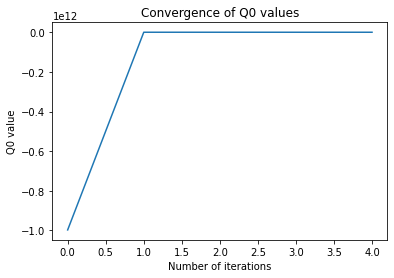

k function: 79704.5202309463


In [138]:
Q0_prev = drain[0].Q_0
eps = 0.001

iterations = []
Q0_values = []

# set the maximum number of iterations
max_iterations = 100

# Итерационный поиск
i = 0
while i < max_iterations:
    Q0, p0, Q_well = find_Q_drain(drain, p0)
    iterations.append(i)
    Q0_values.append(Q0)
    if abs(Q0 - Q0_prev) < eps:
        break

    Q0_prev = Q0

    i += 1

print("Q0:", Q0)
print("p0:", p0)

plt.plot(iterations, Q0_values)
# plt.semilogy() 
plt.xlabel('Number of iterations')
plt.ylabel('Q0 value')
plt.title('Convergence of Q0 values')
plt.show()


# Нахождение целевой функции
def find_k():
    k = Q0 - sum(edge.length * edge.diameter/edge.roughness for edge in edges)
    return k

k = find_k()
print("k function:", k)